PREREQUISITE INSTALLATION

In [ ]:
!pip install scikit-fuzzy
!pip install pyclustering
!pip install scikit-learn-extra

     |████████████████████████████████| 993 kB 5.3 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=55ebc2277773446b3095abdf6746798df545edc3f8fe267901d09dfdefaa1b42
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy
     |████████████████████████████████| 2.6 MB 5.0 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=17fa06dbf3ee993d07c223a4c6eebd4f1a41cb4572527c3fa86f6ec9ce23075a
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully unin



PREREQUISITE IMPORTS



In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from scipy.linalg import norm
from scipy.optimize import minimize
from functools import reduce
import skfuzzy.defuzzify as defuzz
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

Distance between trapezoidal fuzzy numbers:

In [ ]:
def rho(A):
  if A[3]!=A[0]:
    n = (A[2]-A[1])/(A[3]-A[0]) + 2
  else:
    n = 3
  return n/6

def pi(A,r):
  return (r*(A[2]+A[0])+(A[3]+A[0])*(1-r))/2
  
def distA(A1,A2):
  rhoA1 = rho(A1)
  piA1 = pi(A1,rhoA1)
  rhoA2 = rho(A2)
  piA2 = pi(A2,rhoA2)
  d = math.sqrt((rhoA1-rhoA2)*(rhoA1-rhoA2) + (piA1 - piA2)*(piA1 - piA2))/math.sqrt(1.25)
  return d

Vertex method distance between TFNs

In [ ]:
def distB(a,b):
  d = math.sqrt(((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)/3)
  return d

Distance/Similarity between 2 probability distributions

In [ ]:
def hellinger(p,q):
    return norm(np.sqrt(p) - np.sqrt(q))/np.sqrt(2)

Risk Evaluation Matrix

In [ ]:
def linguisticScale(data):
  # dictionary mapping Linguistic variables to fuzzy numbers
  A={'VP':[0,0,0.1,0.2],'P':[0.1,0.2,0.2,0.3],'MP':[0.2,0.3,0.4,0.5],'M':[0.4,0.5,0.5,0.6],'MG':[0.5,0.6,0.7,0.8],'G':[0.7,0.8,0.8,0.9],'VG':[0.8,0.9,1.0,1.0]}
  B={'VL':[0,0,0.1],'L':[0,0.1,0.3],'ML':[0.1,0.3,0.5],'M':[0.3,0.5,0.7],'MH':[0.5,0.7,0.9],'H':[0.7,0.9,1],'VH':[0.9,1,1]}
  Arpn={'VP':0,'P':1,'MP':2,'M':3,'MG':4,'G':5,'VG':6}
  ADrpn={'VP':6,'P':5,'MP':4,'M':3,'MG':2,'G':1,'VG':0}
  Brpn={'VL':0,'L':1,'ML':2,'M':3,'MH':4,'H':5,'VH':6}
  LA = collections.defaultdict(lambda : A['M'])  # lambda: [...] represents values taken by NaN fields
  LB = collections.defaultdict(lambda : B['M'])
  LArpn = collections.defaultdict(lambda : Arpn['M'])
  LADrpn= collections.defaultdict(lambda : ADrpn['M'])
  LBrpn = collections.defaultdict(lambda : Brpn['M'])
  for k in A:
    LA[k] = A[k]
    LArpn[k] = Arpn[k]
  for k in B:
    LB[k] = B[k]
    LBrpn[k] = Brpn[k]

  sheet=data.keys()
  # convert Data into arrays of trapezoidal and triangular fuzzy numbers for further manipulation
  expA = np.zeros((5,46,5,4))
  expB = np.zeros((5,46,5,3))
  rpnRf = np.zeros((5,46,5))
  n=0
  for j in sheet:
    col = data[j].columns
    row = list(data[j].index)
    c=0
    c1=0
    for i in col:
      if i[1]=='A':
        r=0
        for l in (data[j][i[0]][i[1]]).values:
          expA[n][r][c] = LA[l]
          if i[0]=='D':
            rpnRf[n][r][c]+=LADrpn[l]
          else:
            rpnRf[n][r][c]+=LArpn[l]
          r+=1
        c+=1
      else:
        r1=0
        for l in (data[j][i[0]][i[1]]).values:
          expB[n][r1][c1] = LB[l]
          rpnRf[n][r1][c1]+=LBrpn[l]
          r1+=1
        c1+=1
    n+=1
  x=np.zeros((46,5))
  for i in range(5):
    x+=rpnRf[i]
  x=(x.T)/5
  rp=np.ones(46)
  for i in range(3):
    rp=rp*x[i]
  rpn=np.argsort(rp)+1
  return expA,expB,rpn

In [ ]:
def aggregationMethod(fns):
  if len(fns[0])==4:
    fns = np.transpose(fns)
    a1 = np.average(fns[0])
    a3 = np.average(fns[1])
    a2 = (a1 + a3)/2
    a5 = np.average(fns[2])
    a4 = (a3 + a5)/2
    a7 = np.average(fns[3])
    a6 = (a5 + a7)/2
  else:
    fns = np.transpose(fns)
    a1 = np.average(fns[0])
    a4 = np.average(fns[1])
    a2 = (2*a1 + a4)/3
    a3 = (a1 + 2*a4)/3
    a7 = np.average(fns[2])
    a5 = (2*a4 + a7)/3
    a6 = (a4 + 2*a7)/3
  return [a1,a2,a3,a4,a5,a6,a7]

def aggregateExperts(expA,expB):
  A = np.zeros((46,5,7))
  B = np.zeros((46,5,7))
  ra=np.zeros((46,5))
  rb=np.zeros((46,5))
  aggrA = np.zeros((46,5,4))
  aggrB = np.zeros((46,5,3))
  for i in range(5):
    for j in range(46):
      trfn=[]
      tfn=[]
      for k in range(5):
        trfn.append(expA[k][j][i])
        tfn.append(expB[k][j][i])
      A[j][i] = aggregationMethod(trfn)
      B[j][i] = aggregationMethod(tfn)
      aggrA[j][i] = [A[j][i][0],A[j][i][2],A[j][i][4],A[j][i][6]]
      ra[j][i]=defuzz.centroid(aggrA[j][i],[0,1,1,0])
      aggrB[j][i] = [B[j][i][0],B[j][i][3],B[j][i][6]]
      rb[j][i]=defuzz.centroid(aggrB[j][i],[0,1,0])
  return aggrA,aggrB,A,B,ra,rb

In [ ]:
def fun(p):
  obj=0
  for i in range(len(p)):
    if p[i]==0:
      continue
    else:
      obj = obj - p[i]*(np.log(p[i]))
  return obj

def cons1(p):
  return (np.sum(p)-1)

def cons2(p,A,t):
  s=0
  for i in range(len(p)):
    s+=A[i]*p[i]
  return (s-t)

def cons3(p,x,d):
  s=0
  for i in range(len(p)):
    s+=x[i]*p[i]
  return (s-d)

# read A's
# read B's
# no of Z-numbers = A.len = B.len
# muA ->  0 0.3333 0.6667 1 0.6667 0.3333 0
def calculateRPD(A,B,muA,rb):
  XP=np.zeros((46,5))
  RPD = np.zeros((46,5,7)) #representative probability distributions
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      x = A[i][j]# z number -> xi values
      muA[i] # corresponding muA(membership function) for 'i'th Hazard
      s=0
      z=0
      for k in range(len(x)):
        s+=x[k]*muA[i][k]
        z+=muA[i][k]
      d=s/z
      arg2=(muA[i],rb[i][j])
      arg3=(x,d)
      cons = ({'type': 'eq', 'fun': cons1},{'type': 'eq', 'fun': cons2, 'args': arg2},{'type': 'eq', 'fun':cons3, 'args': arg3})
      bnds = ((0, None),)*(len(x))
      initial = np.ones(len(x))*(1/len(x))
      res1 = minimize(fun, x0=initial, method='SLSQP', bounds=bnds, constraints=cons,  options={'maxiter': 100, 'ftol': 1e-08, 'iprint': 1, 'disp': False, 'eps': 1e-08})
      p=0
      for k in range(len(x)):
        p+=(res1.x[k])*x[k]
      XP[i][j]=p
      rpd=np.zeros(muA.shape[1])
      for k in range(B.shape[2]):
        arg2=(muA[i],B[i][j][k])
        arg3=(x,d)
        cons = ({'type': 'eq', 'fun': cons1},{'type': 'eq', 'fun': cons2, 'args': arg2},{'type': 'eq', 'fun':cons3, 'args': arg3})
        bnds = ((0, None),)*(len(x))
        initial = np.ones(len(x))*(1/len(x))
        res2 = minimize(fun, x0=initial, method='SLSQP', bounds=bnds, constraints=cons,  options={'maxiter': 100, 'ftol': 1e-08, 'iprint': 1, 'disp': False, 'eps': 1e-08})
        if i==0 and j==0:
          print("P",i,j,"=",res2.x)
        rpd += res2.x # representative probability distribution (rpd)
      RPD[i][j]=rpd/(B.shape[2])
  return XP,RPD

In [ ]:
def plotData(ra,rb,XP):
  rv=np.zeros((46,5))
  index_values=[]
  for i in range(46):
    index_values.append('H'+str(i+1))
    for j in range(5):
      rv[i][j]=0.5*(0.5*(ra[i][j]+XP[i][j])+rb[i][j])
  pldata = pd.DataFrame(data = rv.reshape(5,46),index=['O','S','D','C','P'], columns=index_values)
  (pldata.T).to_csv('plot.csv')

Calculating associated risk values of Hazards

In [ ]:
def calculateRisk(aggrA,aggrB):
  riskA=np.zeros(46)
  riskB=np.zeros(46)
  A7=np.zeros((46,7))
  for i in range(46):
    trf=[]
    tf=[]
    for j in range(5):
      trf.append(aggrA[i][j])
      tf.append(aggrB[i][j])
    A7[i]=aggregationMethod(trf)
    tf=np.transpose(tf)
    riskA[i]=defuzz.centroid([A7[i][0],A7[i][2],A7[i][4],A7[i][6]],[0,1,1,0])
    riskB[i]=defuzz.centroid([np.average(tf[0]),np.average(tf[1]),np.average(tf[2])],[0,1,0])
  print("A7: ",A7[0])
  print("rb: ",np.average(tf[0]),np.average(tf[1]),np.average(tf[2]))
  print("ra: ",riskA[0])
  print("rb: ",riskB[0])
  xpec=np.zeros(46)
  for i in range(A7.shape[0]):
    x=A7[i]
    s=0
    z=0
    for k in range(len(x)):
      s+=x[k]*muA[i][k]
      z+=muA[i][k]
    d=s/z
    arg2=(muA[i],riskB[i])
    arg3=(x,d)
    cons=({'type': 'eq', 'fun': cons1},{'type': 'eq', 'fun': cons2, 'args': arg2},{'type': 'eq', 'fun':cons3, 'args': arg3})
    bnds = ((0, None),)*(A7.shape[1])
    initial=np.ones(len(x))*(1/len(x))
    res=minimize(fun,x0=initial,method='SLSQP',bounds=bnds,constraints=cons,options={'maxiter': 100, 'ftol': 1e-08, 'iprint': 1, 'disp': False, 'eps': 1e-08})
    if i==0:
      print(res.x)
    p=0
    for j in range(len(x)):
      p+=(res.x[j])*x[j]
    xpec[i]=p
  print("xp: ",xpec[0])
  rvalue=np.zeros(46)
  for i in range(46):
    rvalue[i]=0.5*(0.5*(riskA[i]+xpec[i])+riskB[i])
  print("rvalue: ",rvalue[0])
  rank=list(np.argsort(rvalue)+1)
  print(rank) #[21, 32, 35, 41, 46, 2, 22, 8, 25, 36, 4, 39, 3, 28, 30, 31, 33, 34, 5, 23, 24, 19, 7, 40, 20, 38, 15, 44, 17, 43, 18, 37, 45, 27, 6, 42, 9, 13, 29, 26, 16, 10, 14, 1, 12, 11]
  return rank

FUNCTION FOR CALCULATING DISTANCE MATRIX

In [ ]:
def calculateDistanceMatrix(aggrA,aggrB,RPD):
  DistMat = np.zeros((46,46))
  for i in range(5):
    D = np.zeros((46,46))
    for j in range(46):
      for k in range(j):
        a = distA(aggrA[j][i],aggrA[k][i])     #distance between 2 TrFNs
        b = distB(aggrB[j][i],aggrB[k][i])     #distance between 2 TFNs
        p = hellinger(RPD[j][i],RPD[k][i])     #distance between 2 representative probability distribution
        D[j][k] = (0.5*(a+p) + b)/2            #combining these 3 distances to get a single metric
        if i==0 and j==2:
          if k==1:
            print("Z1=",aggrA[j][i],aggrB[j][i])
            print("Z2=",aggrA[k][i],aggrB[k][i])
            print("P1=",RPD[j][i],"P2=",RPD[k][i])
            print("da=",a,"db=",b,"dp=",p)
            print("D=",D[j][k])
        D[k][j] = D[j][k]                      #since it is symmetric matrix                  
    DistMat+=D
  DistanceMatrix = DistMat/5
  return DistanceMatrix

In [ ]:
def knn(Dmat,k):
  y=[]
  for i in range(46):
    d = (np.sort(Dmat[i]))
    for j in range(k):
      if d[j]!=0:
        y.append(d[j])
  y=np.unique(y)
  x=[i for i in range(len(y))]
  plt.plot(x,np.sort(y))
  plt.title('%s' % (str(k)+"-distance graph"))
  plt.xlabel("Hazards")
  plt.ylabel("k-distances")
  plt.show()
  name=str(k)+"-distance graph.jpg"
  plt.savefig(name)
  return np.sort(y)

In [ ]:
def  set2List(NumpyArray):
    list  =  []
    for  item  in  NumpyArray:
        list.append(item.tolist())
    return  list
  
def muMinP(value,minP,maxP):
    if value<=minP:
        return 0
    elif value<maxP:
          return  (value - minP)/(maxP - minP)
    else:
          return 1

def dens(j,nbdPts,DistanceMatrix,epsMin,epsMax):
  d = 0
  for  k  in  nbdPts:
    membership  =  0
    if DistanceMatrix[j][k] <= epsMin:
      membership  =  1
    elif DistanceMatrix[j][k] <= epsMax:
      membership = ((epsMax - DistanceMatrix[j][k])/(epsMax - epsMin))
    else:
      membership  =  0
    d = d + membership
  return d

def FuzzyDBSCAN(DistanceMatrix,epsMin,epsMax, minP,maxP):
    m = DistanceMatrix.shape[0]
    Visited = np.zeros(m,'int')
    Type = np.ones(m)*2
    Membership = []
    for i in range(m):
        Membership.append({})
    Clusters=[]
    C=[]
    PointCNumber=np.zeros(m)
    PointCNumberIndex=1
    nbdPts=[]
    for i in range(m):
        if  Visited[i] == 0:
            Visited[i] = 1
            nbdPts = np.where(DistanceMatrix[i]<epsMax)[0]
            nbdPts = set2List(nbdPts)            
            density = dens(i,nbdPts,DistanceMatrix,epsMin,epsMax) 
  
            if  muMinP(density,minP,maxP)==0:
                Type[i] = -1
                Visited[i] = 0

            else:
                for k in nbdPts:
                    if PointCNumber[k]!=PointCNumberIndex and Type[k] == 0 and k!=i:
                        Visited[k] = 0
                C = []
                C.append(i)
                PointCNumber[i] = PointCNumberIndex
                Type[i] = 1
                Membership[i][PointCNumberIndex] = round(muMinP(density,minP,maxP),5)
                ExpandCluster(nbdPts,C,minP,maxP,epsMin,epsMax,Visited,DistanceMatrix,PointCNumber,PointCNumberIndex,Type,Membership)
                C.append(nbdPts[:])
                Clusters.append(C[:])
                PointCNumberIndex=PointCNumberIndex+1
    return  PointCNumber,PointCNumberIndex-1,Membership,Type
  
def ExpandCluster(nbdPts,C,minP,maxP,epsMin,epsMax,Visited,DistanceMatrix,PointCNumber,PointCNumberIndex,Type,Membership):
    Neighbors=[]

    for  i  in  nbdPts:
        if  Visited[i]==0:
            Visited[i]=1
            Neighbors=np.where(DistanceMatrix[i]<epsMax)[0]
            density  =  0
            for  k  in  nbdPts:
                membership  =  0
                if  DistanceMatrix[i][k]<=epsMin:
                    membership  =  1

                elif  DistanceMatrix[i][k]<=epsMax:
                    membership  =  ((epsMax-DistanceMatrix[i][k])/(epsMax-epsMin))
                
                else:
                    membership  =  0
                density  =  density  +  membership
            m  =  round(muMinP(density,minP,maxP),3)
            if  m  >  0:
                for k in Neighbors:
                    if PointCNumber[k]!=PointCNumberIndex and Type[k] == 0 and k!=i:
                        Visited[k] = 0
                for  j  in  Neighbors:
                    try:
                        nbdPts.index(j)
                    except  ValueError:
                        nbdPts.append(j)
                Type[i]  =  1
                Membership[i][PointCNumberIndex]  =  m
            else:
                Type[i]  =  0
                minimum  =  9999
                for  k  in  Neighbors:
                    if  k  !=  i:
                        if  DistanceMatrix[i][k]  <  epsMin:
                            h  =  1
                        else  :
                            h  =  (epsMax  -  DistanceMatrix[i][k])  /  (epsMax  -  epsMin)
                        Neighbors2=np.where(DistanceMatrix[k]<epsMax)[0]
                        density  =  0
                        for  p  in  Neighbors2:
                            membership  =  0
                            if  DistanceMatrix[k][p]<=epsMin:
                                membership  =  1

                            elif  DistanceMatrix[p][k]<=epsMax:
                                membership  =  ((epsMax-DistanceMatrix[i][k])/(epsMax-epsMin))
                            
                            else:
                                membership  =  0
                            density  =  density  +  membership
                        m  = round(muMinP(density,minP,maxP),3)
                        mini  =  9999
                        if  m>0  and  h>0:
                            mini  =  min(m, round(h,3))
                        if  mini  <  minimum:
                            minimum  =  mini
                if minimum == 9999:
                    Membership[i][PointCNumberIndex]  =  0
                else:
                    Membership[i][PointCNumberIndex] = minimum                                    

        if  PointCNumber[i]==0:
            PointCNumber[i]=PointCNumberIndex
    return nbdPts

def FDBSCAN_Clustering(D,epsMin,epsMax,minP,maxP):
  result,C_len,Membership_value,Type=FuzzyDBSCAN(D,epsMin,epsMax,minP,maxP)
  print("Number of clusters: ",C_len)
  cl=dict({})
  for i in range(C_len):
    cl[i+1]=[]
  cl['Noise']=[]
  for i in range(len(result)):
    if Type[i]==-1:
      cl['Noise'].append(i+1)
    for j in range(C_len):
      if result[i]==j+1:
        cl[j+1].append(i+1)
  return result-1,cl,C_len

In [ ]:
def labelToRisk(rank,labels,cnum):
  maprisk=dict({})
  maprisk[-1]='Noise'
  for i in range(cnum):
    l=0
    h=0
    m=0
    for j in labels:
      if j!=i:
        continue
      else:
        if rank.index(j+1)<10:
          l+=1
        if rank.index(j+1)>40:
          h+=1
        else:
          m+=1
    if h>0:
      maprisk[i]='H'
    elif l>0:
      maprisk[i]='L'
    elif m>0:
      maprisk[i]='M'
  print(maprisk)
  for i in range(len(labels)):
    labels[i]=maprisk[labels[i]]
  return labels

In [ ]:
def visualize(rank,labels,cnum,algo):
  # Visualizing 5-D mix data using bubble charts
  # leveraging the concepts of hue, size and depth
  pldata=pd.read_csv('plot.csv')
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  #t = fig.suptitle('Wine Residual Sugar - Alcohol Content - Acidity - Total Sulfur Dioxide - Type', fontsize=14)
  xs = list(pldata['O'])
  ys = list(pldata['S'])
  zs = list(pldata['D'])
  data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
  ss = list((pldata['C']**2)*100)
  cl=labelToRisk(rank,labels,cnum)#[1, -1,  0,  0,  0, -1, -1,  0, -1,  2, -1, -1,  2, -1, -1,  2, -1, -1,  1,  2, -1,  0,  0,  0,  0,  1,  2, -1,  1,  0,  0, -1,  0,  0,  0,  0, -1, -1, -1, -1,  0,  1,  2,  2,  1, -1]#fdbsc
  #cl=[1,0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2,2 ,2 ,2 ,0 ,1 ,1 ,1 ,1, 0]#agglomerative
  #cl=[2, -1,  0,  0,  0, -1, -1,  0, -1,  1, -1,  2,  1, -1, -1,  1, -1, -1,  2,  1, -1,  0,  0,  0, 0 , 2 , 1 ,-1 , 2 , 0 , 0 ,-1 , 0,  0,  0,  0, -1,  2,  2, -1,  0,  2,  1,  1,  2, -1]#dbscan
  #cl=[1, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 0]#spectral
  #cl=[0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 2, 0, 1, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 2, 2, 0, 1]#kmedoids
  #cl=clustering.labels_
  colors=[]
  for i in range(46):
    if cl[i]=='H':
      colors.append('red')
    if cl[i]=='M':
      colors.append('yellow')
    if cl[i]=='L':
      colors.append('green')
    elif cl[i]=='Noise':
      colors.append('gray')

  i=0
  for d, color, size in zip(data_points, colors, ss):
    x, y, z = d
    if color=='red':
      s1=ax.scatter(x, y, z, s=size, c=color,alpha=pldata['P'][i])
    elif color=='yellow':
      s2=ax.scatter(x, y, z, s=size, c=color,alpha=pldata['P'][i])
    elif color=='green':
      s3=ax.scatter(x, y, z, s=size, c=color,alpha=pldata['P'][i])
    else:
      s4=ax.scatter(x, y, z, s=size, c=color,alpha=pldata['P'][i])
    #ax.text(x,y,z,  '%s' % (str(i+1)), size=10, zorder=1, color='k')
    i+=1
  if algo!="Spectral.jpg":
    plt.legend(handles=[s1,s2,s3,s4],labels=['High Risk','Medium Risk','Low Risk','Noise'])
  else:
    plt.legend(handles=[s1,s2,s3],labels=['High Risk','Medium Risk','Low Risk'])
  plt.show()
  plt.savefig(algo)

PREPARE DATA AND CALCULATE DISTANCES

In [ ]:
muAdata=pd.read_excel('muA.xlsx',sheet_name=0,index_col=0)
muA=muAdata.values
data=pd.read_excel('Data.xlsx', sheet_name=None, header = [1,2], index_col=0)
expA,expB,RPN=linguisticScale(data)
aggrA,aggrB,A,B,ra,rb=aggregateExperts(expA,expB)
'''
for i in range(5):
  a = pd.DataFrame(data = aggrA.reshape(5,46,4)[i])
  n='aggrA'+str(i)+'.xlsx'
  a.to_excel(n)
  b=pd.DataFrame(data=aggrB.reshape(5,46,3)[i])
  n='aggrB'+str(i)+'.xlsx'
  b.to_excel(n)
  a=pd.DataFrame(data=A.reshape(5,46,7)[i])
  n='A'+str(i)+'.xlsx'
  a.to_excel(n)
  b=pd.DataFrame(data=B.reshape(5,46,7)[i])
  n='B'+str(i)+'.xlsx'
  b.to_excel(n)
'''
XP,RPD=calculateRPD(A,B,muA,rb)
plotData(ra,rb,XP)
rank=calculateRisk(aggrA,aggrB)
DistanceMatrix=calculateDistanceMatrix(aggrA,aggrB,RPD)
dig = pd.DataFrame(data = DistanceMatrix)

P 0 0 = [9.84330607e-16 0.00000000e+00 3.63630322e-01 3.39339344e-01
 2.97030334e-01 1.73472348e-15 0.00000000e+00]
P 0 0 = [1.71006606e-15 8.15320034e-17 2.83550250e-01 4.99499499e-01
 2.16950250e-01 1.13444766e-14 0.00000000e+00]
P 0 0 = [5.82384855e-14 0.00000000e+00 2.03470170e-01 6.59659660e-01
 1.36870170e-01 0.00000000e+00 5.75741993e-14]
P 0 0 = [2.86275986e-14 0.00000000e+00 1.23390090e-01 8.19819820e-01
 5.67900901e-02 0.00000000e+00 2.96016632e-14]
P 0 0 = [2.77555756e-17 1.11022302e-16 9.33602063e-02 8.79879870e-01
 2.67599322e-02 2.77555756e-17 0.00000000e+00]
P 0 0 = [3.91353616e-15 0.00000000e+00 6.74506994e-02 9.32549310e-01
 0.00000000e+00 0.00000000e+00 1.21014310e-14]
P 0 0 = [4.39305514e-11 0.00000000e+00 7.54834331e-02 9.24978841e-01
 0.00000000e+00 3.20370223e-10 0.00000000e+00]
A7:  [0.58  0.63  0.68  0.704 0.728 0.766 0.804]
rb:  0.54 0.732 0.8719999999999999
ra:  0.6967058823529412
rb:  0.8333333333333334
[0.00000000e+00 4.66571226e-14 2.78000244e-01 4.99499500

In [ ]:
for i in range(5):
  a = pd.DataFrame(data = RPD.reshape(5,46,7)[i])
  n='RPD'+str(i)+'.xlsx'
  a.to_excel(n,float_format='%.2f')

In [ ]:
print(np.max(DistanceMatrix))

0.20204502405428357


DETERMINE PARAMETERS OF FUZZY DBSCAN

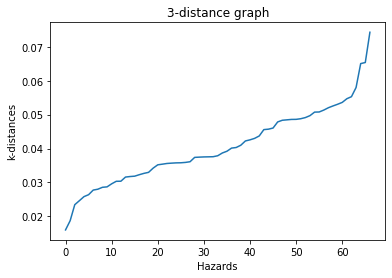

<Figure size 432x288 with 0 Axes>

In [ ]:
g=knn(DistanceMatrix,3)

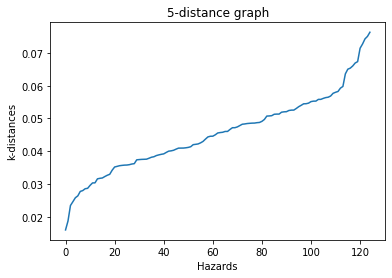

<Figure size 432x288 with 0 Axes>

In [ ]:
t=knn(DistanceMatrix,5)  # 0.033, 0.04, 0.055, 0.075,0.08, ~0.1

CLUSTER AND COMPARE BETWEEN DIFFERENT FMEA METHODS

FUZZY DBSCAN-
Number of clusters:  3
Clustering:  [0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, -1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0]
{1: [1, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 29, 30, 37, 38, 39, 40, 41, 42, 43, 44, 45], 2: [2, 3, 5, 8, 23, 24, 25, 28, 31, 33, 34, 36], 3: [4, 22, 35], 'Noise': [9, 21, 32, 46]}
Silhoutte score:  0.2387653435868016
Visualization: 
{-1: 'Noise', 0: 'H', 1: 'L', 2: 'M'}


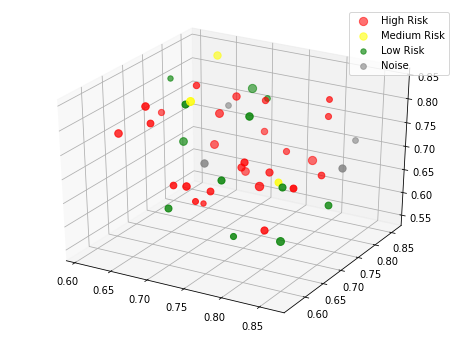

<Figure size 432x288 with 0 Axes>

In [ ]:
print("FUZZY DBSCAN-")
# Fuzzy DBSCAN on FMEA
result,clust,cnum=FDBSCAN_Clustering(DistanceMatrix,0.037,0.057,3,5)
print("Clustering: ",list(result))
print(clust)
print("Silhouette score: ",metrics.silhouette_score(DistanceMatrix, result,metric='precomputed')) # cluster validation
print("Visualization: ")
visualize(rank,list(result),cnum,"FuzzyDBSCAN.jpg")

COMPARISON WITH OTHER METHODS

DBSCAN-
Clustering:  [ 0 -1 -1  1  2  0 -1 -1 -1  0  0  0  0 -1  0  0 -1  0  0  0 -1  1  0  0
 -1  0  0  0  0  0  0 -1  2  2  1 -1  0 -1 -1  0 -1  0  0  0  0 -1]
Silhoutte score:  0.10007627158918375
Visualization: 
{-1: 'Noise', 0: 'H', 1: 'L', 2: 'M'}


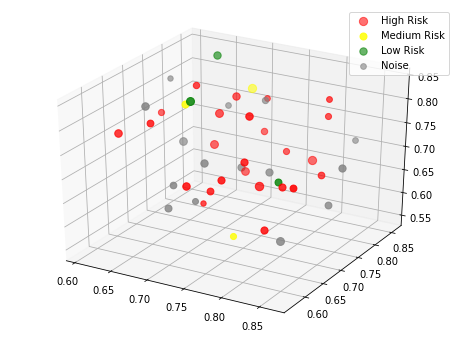

<Figure size 432x288 with 0 Axes>

In [ ]:
# sklearn DBSCAN on pre-computed Distance Matrix
print("DBSCAN-")
dbsc = DBSCAN(eps=0.04, min_samples=3, metric='precomputed').fit(DistanceMatrix)
print("Clustering: ",dbsc.labels_)
print("Silhouette score: ",metrics.silhouette_score(DistanceMatrix, dbsc.labels_,metric='precomputed')) # validation score
print("Visualization: ")
visualize(rank,list(dbsc.labels_),cnum,"DBSCAN.jpg")

In [ ]:
'''
SC = SpectralClustering(n_clusters=3,affinity='precomputed',assign_labels='discretize',random_state=0).fit(1/(1+DistanceMatrix))
print("Clustering: ",SC.labels_)
print("Silhoutte score: ",metrics.silhouette_score(DistanceMatrix, SC.labels_,metric='precomputed')) # validation score
print("Visualization: ")
visualize(rank,list(SC.labels_),cnum,"Spectral.jpg")
'''

'\nSC = SpectralClustering(n_clusters=3,affinity=\'precomputed\',assign_labels=\'discretize\',random_state=0).fit(1/(1+DistanceMatrix))\nprint("Clustering: ",SC.labels_)\nprint("Silhoutte score: ",metrics.silhouette_score(DistanceMatrix, SC.labels_,metric=\'precomputed\')) # validation score\nprint("Visualization: ")\nvisualize(rank,list(SC.labels_),cnum,"Spectral.jpg")\n'

PLOT FOR COMPARITATIVE ANALYSIS

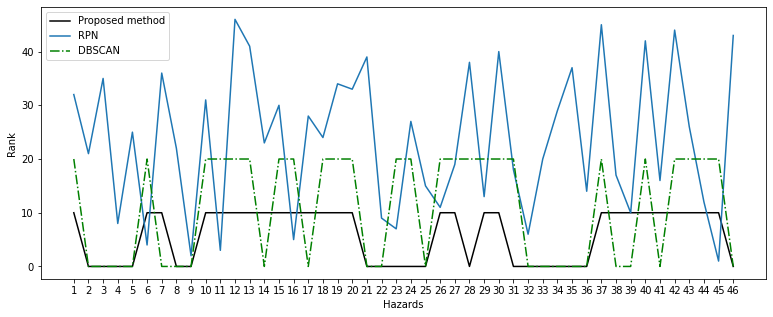

In [ ]:
import matplotlib.pyplot as plt
x=[i+1 for i in range(46)]
y1=[10*int(i==0) for i in result]
y2=[20*int(i==0) for i in dbsc.labels_]
plt.figure(figsize=(13, 5))
plt.plot(x,y1,'k')
plt.plot(x,RPN)
plt.plot(x,y2,'g-.')
plt.xticks(np.arange(1, 47, 1))
plt.xlabel("Hazards")
plt.ylabel("Rank")
plt.legend(["Proposed method","RPN","DBSCAN"])